Loading dataset. It might take a while ...
0.3365633487701416


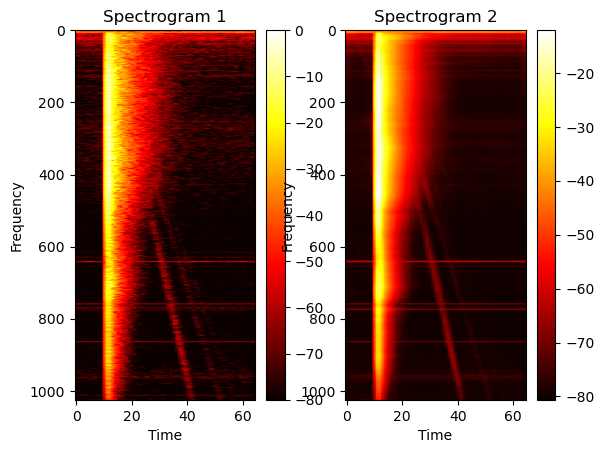

In [1]:
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import subprocess
import argparse
import os
import tempfile
import math
import time
from pathlib import Path

from network import NAF
from sound_loader import sound_samples

# Device selection
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset
print('Loading dataset. It might take a while ...')
dataset = sound_samples(num_samples=20)

# Get one sample to compare to
s = 1
m = 100
sample = dataset.spectrograms[s,m,:]
src = torch.tensor(dataset.posSrc[s, :]).unsqueeze(1).to(device)
mic = torch.tensor(dataset.posMic[m, :]).unsqueeze(1).to(device)

# Load NAF with selected configuration
net = NAF(input_dim = 416, min_xy=dataset.min_pos[:2], max_xy=dataset.max_pos[:2]).to(device)
state_dict = torch.load('saved/net_20230830_141755_loss_0.0455.pth')
net.load_state_dict(state_dict)
net.eval()

start_time = time.time()
out = net.spectrogram_at(src, mic)
exec_time = time.time() - start_time
print(exec_time)
out = (out * dataset.std) + dataset.mean



# First Image
plt.subplot(1, 2, 1)
plt.imshow(sample, cmap='hot', aspect='auto')
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Spectrogram 1')

# Second Image
plt.subplot(1, 2, 2)
plt.imshow(out.cpu(), cmap='hot', aspect='auto')
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Spectrogram 2')

plt.show()

Loading IRs ...


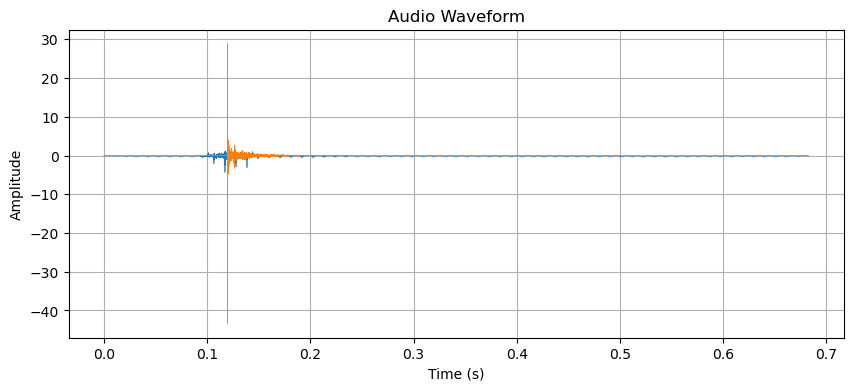

In [7]:
import sys
sys.path.append("utils/")
import irutilities as irutil
from pathlib import Path
import librosa

path = Path('mesh_rir/S32-M441_npy/')
print('Loading IRs ...')
posMic, posSrc, ir = irutil.loadIR(path)

# Convert the magnitude spectrogram back to linear scale
spectrogram = librosa.db_to_amplitude(out.cpu().numpy())

# Reconstruct the audio signal using the inverse STFT
reconstructed_audio = librosa.istft(spectrogram, hop_length=512, length=len(ir[0,0,:]))



time = np.arange(0, len(ir[0,0,:])) / 48000

# Plot the audio waveform
plt.figure(figsize=(10, 4))
plt.plot(time, reconstructed_audio*12000, linewidth=0.5)
plt.plot(time, ir[0,0,:], linewidth=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Audio Waveform')
plt.grid(True)
plt.show()